In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.optim import Adam
from sklearn.model_selection import KFold
import math
import time as ti

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

from sklearn.metrics import classification_report # performance measurement 


if torch.cuda.is_available():
  dev = "cuda:3"
  print("yey")
device = torch.device(dev)


# Define a function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('2D_pixel_proj_class_norm_per_exp_train_test_XRA_11x11_conf/all-exp-'+'2D_pixel_proj_class_norm_per_exp_train_test-XRA-11x11-'+'.png')

    plt.clf()

# Define relevant variables for the ML task
batch_size = 32
num_classes = 6
learning_rate = 0.01 #0.01
num_epochs = 100#150 #50 #10 #30

#Load dataset
df = pd.read_json('../get_2D_pixel_Norm_per_exp_train_test/lidar_norm_train_test_2d_pixel_6class_norm_XRA_10x10.json')


df.drop(df[df['class'] == 'dew'].index, inplace = True)
df.drop(df[df['class'] == 'dirt_05mm'].index, inplace = True)
df.drop(df[df['class'] == 'dirt_10mm'].index, inplace = True)
df.drop(df[df['class'] == 'dirt_15mm'].index, inplace = True)

df_add = df

#get data class=ref without cover
df_no_cover =df_add[df_add['class'] == 'no_cover']
df_ref_train = df_no_cover.sample(frac=0.80,random_state=1)
df_ref_test = df_no_cover.drop(df_ref_train.index)


#get data class=ref with cover
df_cover =df_add[df_add['class'] == 'cover']
df_ref_wh_train = df_cover.sample(frac=0.80,random_state=1)
df_ref_wh_test = df_cover.drop(df_ref_wh_train.index)

#get data class oil, foam, dirt, water from exp 1,2,3,4
#get training data
df_water_all=df_add[df_add['class'] == 'water']
df_water_1=df_water_all[df_water_all['exp'].isin([1])] 
df_water_2=df_water_all[df_water_all['exp'].isin([2])] 
df_water_3=df_water_all[df_water_all['exp'].isin([3])] 
df_water_4=df_water_all[df_water_all['exp'].isin([4])] 
df_water_5=df_water_all[df_water_all['exp'].isin([5])] 


df_oil_all=df_add[df_add['class'] == 'oil']
df_oil_1=df_oil_all[df_oil_all['exp'].isin([1])] 
df_oil_2=df_oil_all[df_oil_all['exp'].isin([2])] 
df_oil_3=df_oil_all[df_oil_all['exp'].isin([3])] 
df_oil_4=df_oil_all[df_oil_all['exp'].isin([4])] 
df_oil_5=df_oil_all[df_oil_all['exp'].isin([5])] 

df_foam_all=df_add[df_add['class'] == 'foam']
df_foam_1=df_foam_all[df_foam_all['exp'].isin([1])] 
df_foam_2=df_foam_all[df_foam_all['exp'].isin([2])] 
df_foam_3=df_foam_all[df_foam_all['exp'].isin([3])] 
df_foam_4=df_foam_all[df_foam_all['exp'].isin([4])] 
df_foam_5=df_foam_all[df_foam_all['exp'].isin([5])] 

df_dirt_all=df_add[df_add['class'] == 'dirt']
df_dirt_1=df_dirt_all[df_dirt_all['exp'].isin([1])] 
df_dirt_2=df_dirt_all[df_dirt_all['exp'].isin([2])] 
df_dirt_3=df_dirt_all[df_dirt_all['exp'].isin([3])] 
df_dirt_4=df_dirt_all[df_dirt_all['exp'].isin([4])] 
df_dirt_5=df_dirt_all[df_dirt_all['exp'].isin([5])] 

yey


In [2]:
def flatChannels(x):
    size = x.size()
    # print("flatChannels")
    # print(size)
    return x.view(size[0],size[1],size[2]*size[3])

def globalAvgPool2D(x):        
    return flatChannels(x).mean(dim=-1)

def globalMaxPool2D(x):
    return flatChannels(x).max(dim=-1)
    
class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1) # 10x10

        # self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        # output = self.bn(output)
        output = self.relu(output)

        return output

class Net(nn.Module):
    def __init__(self,num_classes):
        super(Net,self).__init__()

        #Create 14 layers of the unit with max pooling in between
        self.unit0 = Unit(in_channels=3,out_channels=16)
        self.unit15 = Unit(in_channels=16,out_channels=32)
        self.unit16 = Unit(in_channels=32,out_channels=64)
    
        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit0, self.unit15, self.unit16) #BEST
        self.fc = nn.Linear(in_features=64,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = globalAvgPool2D(output) 
        output = self.fc(output)
        return output


In [3]:
def train_net(num_epochs): #Training your network
    losses = []
    for epoch in range(num_epochs): # loop over the dataset multiple times
     
        train_acc = 0.0
        train_loss = 0.0
     

        for i, data in enumerate(list_train_tensor, 0):
     
            #get the input; data is a list of [input, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass 
            outputs = net(inputs)
    
     
            loss = criterion(outputs, labels)

            # backward and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, prediction = torch.max(outputs.data, 1)
            train_acc += torch.sum(prediction == labels.data)

        #Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / df_train_X_tensor.size()[0]
        train_loss = train_loss / df_train_X_tensor.size()[0]

         # Print the metrics
        print("Epoch {}, Train Accuracy: {} , Train Loss: {}".format(epoch, train_acc, train_loss))
            # print statistics
        losses.append(loss.data.cpu())
     
    plt.plot(losses, label ='Training loss')
    plt.show()
    print('Finished Training')


In [4]:
#skenario A 1234
#split dataset to data train and data test
frame_A_train = [df_ref_train, df_ref_wh_train, df_water_1, df_water_2, df_water_3, df_water_4, df_oil_1, df_oil_2, df_oil_3, df_oil_4, df_foam_1, df_foam_2, df_foam_3, df_foam_4,df_dirt_1, df_dirt_2, df_dirt_3, df_dirt_4]

df_A_train = pd.DataFrame()

for df in frame_A_train:
    df_A_train = df_A_train.append(df)

frame_A_test = [df_ref_test, df_ref_wh_test, df_water_5, df_oil_5, df_foam_5, df_dirt_5]

df_A_test = pd.DataFrame()

for df in frame_A_test:
    df_A_test = df_A_test.append(df)

/tmp/ipykernel_2791025/3170075881.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_A_train = df_A_train.append(df)
/tmp/ipykernel_2791025/3170075881.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_A_train = df_A_train.append(df)
/tmp/ipykernel_2791025/3170075881.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_A_train = df_A_train.append(df)
/tmp/ipykernel_2791025/3170075881.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_A_train = df_A_train.append(df)
/tmp/ipykernel_2791025/3170075881.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [5]:
df_A_train_clean =  df_A_train.drop('exp', axis=1)
df_A_test_clean =  df_A_test.drop('exp', axis=1)

df_A_train_clean = df_A_train_clean.sample(frac = 1,random_state=1)
df_A_test_clean = df_A_test_clean.sample(frac = 1,random_state=1)

df_A_train_X = df_A_train_clean.drop('class', axis=1)
df_A_train_Y = df_A_train_clean['class']

df_A_test_X = df_A_test_clean.drop('class', axis=1)
df_A_test_Y = df_A_test_clean['class']

In [6]:
df_train_X = df_A_train_X
df_train_Y = df_A_train_Y

df_test_X = df_A_test_X
df_test_Y = df_A_test_Y

Training for FOLD: 
Epoch 0, Train Accuracy: 0.25168055295944214 , Train Loss: 0.05112413709027115
Epoch 1, Train Accuracy: 0.6349824666976929 , Train Loss: 0.02999519303332865
Epoch 2, Train Accuracy: 0.7968539595603943 , Train Loss: 0.016562507704449263
Epoch 3, Train Accuracy: 0.8451195955276489 , Train Loss: 0.01226190319342394
Epoch 4, Train Accuracy: 0.8670341372489929 , Train Loss: 0.01067868768908414
Epoch 5, Train Accuracy: 0.8869319558143616 , Train Loss: 0.008895036819786371
Epoch 6, Train Accuracy: 0.9077708721160889 , Train Loss: 0.0073407123991721225
Epoch 7, Train Accuracy: 0.91180419921875 , Train Loss: 0.0067735408057397846
Epoch 8, Train Accuracy: 0.9146275520324707 , Train Loss: 0.0065154731128405875
Epoch 9, Train Accuracy: 0.9264586567878723 , Train Loss: 0.005701649252402427
Epoch 10, Train Accuracy: 0.9303575754165649 , Train Loss: 0.0053312451162724345
Epoch 11, Train Accuracy: 0.9339876174926758 , Train Loss: 0.0050850271348247735
Epoch 12, Train Accuracy: 0.93

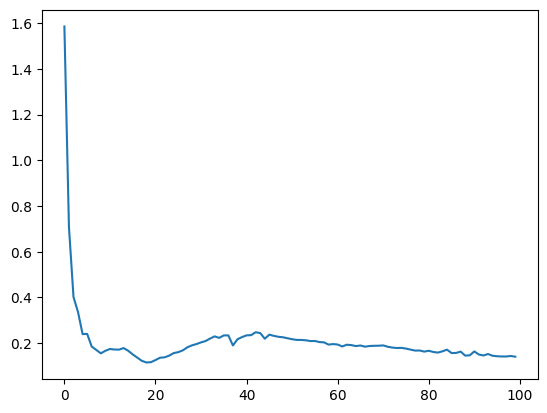

Finished Training
Accuracy of the network on the 1792 test images: 98 %


<Figure size 640x480 with 0 Axes>

In [7]:

encoded_train_Y = df_train_Y.map({'no_cover':0, 'cover':1, 'dirt':2, 'foam':3, 'oil':4, 'water':5})
encoded_test_Y = df_test_Y.map({'no_cover':0, 'cover':1, 'dirt':2, 'foam':3, 'oil':4, 'water':5})

Y_train_dummy=encoded_train_Y
Y_test_dummy=encoded_test_Y


#convert data train to tensor
list_df_train_X = []
for item in range(len(df_train_X['data'])):
    list_df_train_X.append(df_train_X['data'].iloc[item])

df_train_X_tensor = torch.FloatTensor(list_df_train_X)

#convert data test to tensor
list_df_test_X = []
for item in range(len(df_test_X['data'])):
    list_df_test_X.append(df_test_X['data'].iloc[item])

df_test_X_tensor = torch.FloatTensor(list_df_test_X)


# convert label to tensor
encoded_train_Y_tensor = torch.from_numpy(Y_train_dummy.to_numpy())
encoded_test_Y_tensor = torch.from_numpy(Y_test_dummy.to_numpy())

# # get batch for each FOLD TRAINING    
num_batches = math.ceil(df_train_X_tensor.size()[0]/batch_size)
train_X_raw = [df_train_X_tensor[batch_size*y:batch_size*(y+1),:,:] for y in range(num_batches)]
# print(train_X_raw[0].size())

num_batches = math.ceil(encoded_train_Y_tensor.size()[0]/batch_size)
train_Y_raw = [encoded_train_Y_tensor[batch_size*y:batch_size*(y+1)] for y in range(num_batches)]
# print(train_Y_raw[0].size())

List_train_row = len(train_X_raw)
List_train_columns = 2
list_train_tensor = [[ 0 for x in range(List_train_columns)] for i in range (List_train_row)]

for i in range(List_train_row):
    for j in range(List_train_columns):
        list_train_tensor[i][0]=train_X_raw[i]
        list_train_tensor[i][1]=train_Y_raw[i]


# # get batch for each FOLD TESTING
num_batches = math.ceil(df_test_X_tensor.size()[0]/batch_size)
test_X_raw = [df_test_X_tensor[batch_size*y:batch_size*(y+1),:,:] for y in range(num_batches)]
# print(test_X_raw[0].size())

num_batches = math.ceil(encoded_test_Y_tensor.size()[0]/batch_size)
test_Y_raw = [encoded_test_Y_tensor[batch_size*y:batch_size*(y+1)] for y in range(num_batches)]
# print(test_Y_raw[0].size())

List_test_row = len(test_X_raw)
List_test_columns = 2
list_test_tensor = [[ 0 for x in range(List_test_columns)] for i in range (List_test_row)]

for i in range(List_test_row):
    for j in range(List_test_columns):
        list_test_tensor[i][0]=test_X_raw[i]
        list_test_tensor[i][1]=test_Y_raw[i]

print("Training for FOLD: ")

#initialize the network
net = Net(num_classes).cuda(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

criterion = criterion.cuda(device=device)

t = ti.time()

train_net(num_epochs)
elapsed_training = ti.time() - t
training_time = elapsed_training

#save model
torch.save(net, "model_2D_pixel_proj_class_norm_per_exp_train_test_XRA_11x11.pt")
class_name = ['clean', 'cover','dirt', 'foam', 'oil', 'water']


correct = 0
total = 0
list_test_labels = []
list_test_predicted = []

timings_inference = []


with torch.no_grad():
    for i, data in enumerate(list_test_tensor, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        t = ti.time()
        outputs = net(images)
        elapsed_training = ti.time() - t
        timings_inference.append(elapsed_training)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        labels_cpu = labels.tolist()
        predicted_cpu = predicted.tolist() 
        for jj in range(len(labels_cpu)):

            list_test_labels.append(labels_cpu[jj])
            list_test_predicted.append(predicted_cpu[jj])

# print(list_test_labels)
# print(list_test_predicted)
sum_syn = np.sum(timings_inference) # inference time per epoch
mean_syn_per_instance = np.sum(timings_inference)/len(list_test_predicted) # inference time per epoch



correct_CPU = 0
total_CPU = 0
list_test_labels_CPU = []
list_test_predicted_CPU = []

timings_inference_CPU = []

net_CPU = net.cpu()

with torch.no_grad():
    for i, data in enumerate(list_test_tensor, 0):
        images, labels = data
        
        t = ti.time()
        outputs = net_CPU(images)
        elapsed_training = ti.time() - t

        
        timings_inference_CPU.append(elapsed_training)
        
        _, predicted = torch.max(outputs.data, 1)
        total_CPU += labels.size(0)
        correct_CPU += (predicted == labels).sum().item()

        labels_cpu = labels.tolist()
        predicted_cpu = predicted.tolist() 
        for jj in range(len(labels_cpu)):

            list_test_labels_CPU.append(labels_cpu[jj])
            list_test_predicted_CPU.append(predicted_cpu[jj])

sum_syn_CPU = np.sum(timings_inference_CPU) # inference time per epoch
mean_syn_per_instance_CPU = np.sum(timings_inference_CPU)/len(list_test_predicted_CPU) # inference time per epoch


# print(classification_report(list_test_labels,list_test_predicted,target_names=class_name))
# with open("output_2D_pixel_proj_class_norm_per_exp_train_test_XIRA_100x100.txt", "a") as f:
with open("output_2D_pixel_proj_class_norm_per_exp_train_test_XRA_11x11.txt", "a") as f:

    print("CNN 2D - fold: ", file=f)
    print(classification_report(list_test_labels,list_test_predicted,target_names=class_name), file=f)
    print("Training time per Fold:", training_time, file=f)
    print("Inference time per Fold:", sum_syn, file=f)

    print("Inference instance:", len(list_test_predicted), file=f)
    print("Inference time per instance:", mean_syn_per_instance, file=f)

    print("=====CPU=========", file=f)

    print(classification_report(list_test_labels_CPU,list_test_predicted_CPU,target_names=class_name), file=f)
    print("Inference time per Fold CPU:", sum_syn_CPU, file=f)
    print("Inference instance CPU:", len(list_test_predicted_CPU), file=f)
    print("Inference time per instance CPU:", mean_syn_per_instance_CPU, file=f)
    
    print("==============", file=f)
    # compute the confusion matrix     

print('Accuracy of the network on the %d test images: %d %%' % (num_batches*batch_size,
    100 * correct / total))
confusion_mtx = confusion_matrix(list_test_labels, list_test_predicted) 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx,class_name) 
